In [1]:
from helper import *
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from seiz_eeg.dataset import EEGDataset
from sklearn.metrics import f1_score
import pandas as pd

/Users/tugba/Desktop/EPFL/ee452-nml/.venv/lib/python3.10/site-packages/pandera/_pandas_deprecated.py:157: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [4]:
data_path = "data/"  # Replace with your data root path
DATA_ROOT = Path(data_path)

In [5]:
#Creating train and validation Datasets by considering unique patient IDs

clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

clips_tr = clips_tr.copy()
clips_tr['patient_id'] = clips_tr.index.to_series().apply(lambda x: x.split('_')[0])

unique_patients = clips_tr['patient_id'].unique()

np.random.seed(21)
shuffled_patients = np.random.permutation(unique_patients)

val_patients = shuffled_patients[:21]
train_patients = shuffled_patients[21:]

train_df = clips_tr[clips_tr['patient_id'].isin(train_patients)].reset_index(drop=False)
val_df = clips_tr[clips_tr['patient_id'].isin(val_patients)].reset_index(drop=False)

print(f"Train patients: {train_df['patient_id'].nunique()}, Samples: {len(train_df)}")
print(f"Val patients: {val_df['patient_id'].nunique()}, Samples: {len(val_df)}")

train_df.drop(columns=['patient_id'], inplace=True)
train_df.set_index('id', inplace=True)
val_df.drop(columns=['patient_id'], inplace=True)
val_df.set_index('id', inplace=True)

Train patients: 76, Samples: 10277
Val patients: 21, Samples: 2716


In [6]:
train_dataset = EEGDataset(
    train_df,
    signals_root=DATA_ROOT / "train",
    signal_transform=create_spectrogram,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

val_dataset = EEGDataset(
    val_df,
    signals_root=DATA_ROOT / "train",
    signal_transform=create_spectrogram,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [9]:
# Define the CNN model for spectrogram classification

class SpectrogramCNN(nn.Module):
    def __init__(self, in_channels=19):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.attn = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=1),
            nn.Softmax(dim=-1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.net(x)  # [B, 256, H, W]
        B, C, H, W = x.shape
        x_flat = x.view(B, C, -1)  # [B, C, H*W]
        attn_weights = self.attn(x_flat)  # [B, C, H*W]
        x_attn = (x_flat * attn_weights).sum(dim=-1)  # [B, C]
        return self.classifier(x_attn)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SpectrogramCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

num_epochs = 50
train_losses = []
val_losses = []
val_f1s = []

In [11]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)  # [B, 19, F, T]
        yb = yb.float().unsqueeze(1).to(device) # [B, 1]

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.float().unsqueeze(1).to(device)

            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs > 0.58).float()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(yb.view(-1).cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_f1s.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {f1:.4f}")

Epoch 1/50 - Train Loss: 0.4411, Val Loss: 0.5154, Val F1: 0.0000
Epoch 2/50 - Train Loss: 0.3836, Val Loss: 0.4849, Val F1: 0.1767
Epoch 3/50 - Train Loss: 0.3518, Val Loss: 0.4609, Val F1: 0.3864
Epoch 4/50 - Train Loss: 0.3369, Val Loss: 0.4397, Val F1: 0.5067
Epoch 5/50 - Train Loss: 0.3242, Val Loss: 0.4368, Val F1: 0.4892
Epoch 6/50 - Train Loss: 0.3154, Val Loss: 0.4301, Val F1: 0.5359
Epoch 7/50 - Train Loss: 0.3056, Val Loss: 0.4145, Val F1: 0.5993
Epoch 8/50 - Train Loss: 0.2996, Val Loss: 0.4041, Val F1: 0.6800
Epoch 9/50 - Train Loss: 0.2927, Val Loss: 0.3914, Val F1: 0.6869
Epoch 10/50 - Train Loss: 0.2857, Val Loss: 0.4027, Val F1: 0.6622
Epoch 11/50 - Train Loss: 0.2822, Val Loss: 0.3860, Val F1: 0.7101
Epoch 12/50 - Train Loss: 0.2734, Val Loss: 0.3829, Val F1: 0.7081
Epoch 13/50 - Train Loss: 0.2703, Val Loss: 0.3792, Val F1: 0.6908
Epoch 14/50 - Train Loss: 0.2668, Val Loss: 0.3769, Val F1: 0.7231
Epoch 15/50 - Train Loss: 0.2578, Val Loss: 0.3836, Val F1: 0.6677
Epoc

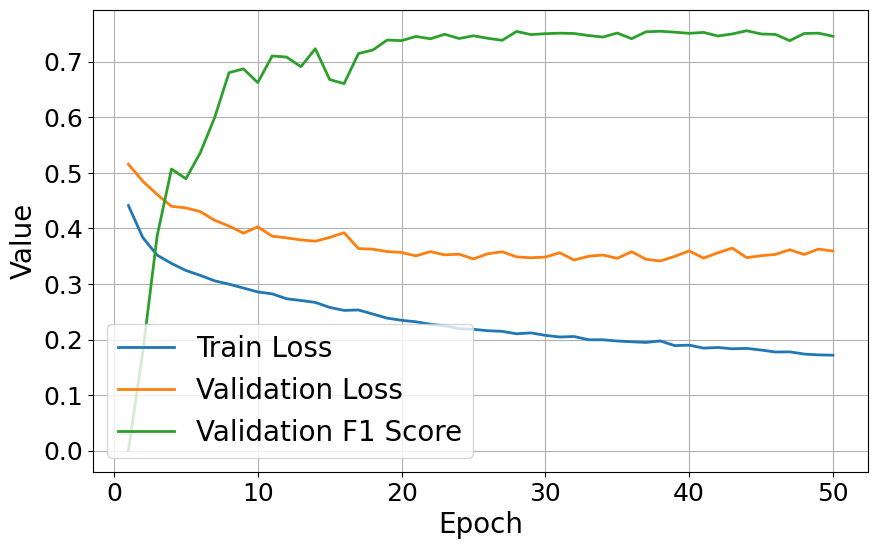

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", linewidth=2)
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", linewidth=2)
plt.plot(range(1, len(val_f1s) + 1), val_f1s, label="Validation F1 Score", linewidth=2)

plt.xlabel("Epoch", fontsize=20)  # Increased font size
plt.ylabel("Value", fontsize=20)  # Increased font size
plt.legend(fontsize=20)           # Increased legend font size
plt.grid(True)
plt.tick_params(axis='both', labelsize=18)  # Increase tick label size
plt.show()


In [13]:
max(val_f1s)

0.7554963357761493